
#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/bhp.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
8859,1/08/2022,39.110001,39.389999,38.919998,39.099998,39.099998,9587051.0,1.35,2.5,125.0
8860,2/08/2022,38.570000,38.680000,38.189999,38.580002,38.580002,8275962.0,1.35,2.5,125.0
8861,3/08/2022,38.240002,38.689999,37.919998,38.610001,38.610001,6491325.0,1.85,2.5,125.0
8862,4/08/2022,38.610001,38.680000,38.080002,38.169998,38.169998,7674397.0,1.85,2.5,125.0
8863,5/08/2022,38.150002,38.959999,38.040001,38.810001,38.810001,6276170.0,1.85,2.5,125.0


In [3]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# Drop all previous records now in MongoDb
db.bhp.drop()

# Insert df records in mongodb
records=df.to_dict('records')
records
db.bhp.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.bhp.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.bhp.delete_one(
    {'Date': last_date}
)



DELETE: 5/08/2022 38.810001


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.bhp.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 4/08/2022 38.169998
Previous last date in MongoDb: 04-08-2022. Today's date: 01-09-2022


In [6]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'BHP.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-04,38.680000,38.080002,38.610001,38.169998,7674397.0,35.847172
2022-08-05,38.959999,38.040001,38.150002,38.810001,6276170.0,36.448227
2022-08-08,39.125000,38.630001,38.799999,39.119999,7532763.0,36.739361
2022-08-09,39.330002,38.639999,38.790001,38.820000,8092683.0,36.457615
2022-08-10,39.040001,38.299999,38.930000,38.299999,7855242.0,35.969261
2022-08-11,39.150002,38.549999,38.810001,39.150002,7429844.0,36.767536
2022-08-12,39.189999,38.759998,39.099998,38.830002,9006138.0,36.467010
2022-08-15,39.400002,38.799999,39.180000,38.919998,6904742.0,36.551529
2022-08-16,41.049999,39.700001,39.930000,40.509998,13033610.0,38.044769


In [7]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-05,38.959999,38.040001,38.150002,38.810001,6276170.0,36.448227
2022-08-08,39.125000,38.630001,38.799999,39.119999,7532763.0,36.739361
2022-08-09,39.330002,38.639999,38.790001,38.820000,8092683.0,36.457615
2022-08-10,39.040001,38.299999,38.930000,38.299999,7855242.0,35.969261
2022-08-11,39.150002,38.549999,38.810001,39.150002,7429844.0,36.767536
2022-08-12,39.189999,38.759998,39.099998,38.830002,9006138.0,36.467010
2022-08-15,39.400002,38.799999,39.180000,38.919998,6904742.0,36.551529
2022-08-16,41.049999,39.700001,39.930000,40.509998,13033610.0,38.044769
2022-08-17,41.330002,40.430000,41.290001,40.849998,11111378.0,38.364079


In [8]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_25024/307716900.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_25024/307716900.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_25024/307716900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,05/08/2022,38.959999,38.040001,38.150002,38.810001,6276170.0,36.448227,1.85,2.5,125
1,08/08/2022,39.125000,38.630001,38.799999,39.119999,7532763.0,36.739361,1.85,2.5,125
2,09/08/2022,39.330002,38.639999,38.790001,38.820000,8092683.0,36.457615,1.85,2.5,125
3,10/08/2022,39.040001,38.299999,38.930000,38.299999,7855242.0,35.969261,1.85,2.5,125
4,11/08/2022,39.150002,38.549999,38.810001,39.150002,7429844.0,36.767536,1.85,2.5,125
5,12/08/2022,39.189999,38.759998,39.099998,38.830002,9006138.0,36.467010,1.85,2.5,125
6,15/08/2022,39.400002,38.799999,39.180000,38.919998,6904742.0,36.551529,1.85,2.5,125
7,16/08/2022,41.049999,39.700001,39.930000,40.509998,13033610.0,38.044769,1.85,2.5,125
8,17/08/2022,41.330002,40.430000,41.290001,40.849998,11111378.0,38.364079,1.85,2.5,125
9,18/08/2022,41.189999,40.500000,40.680000,41.150002,10311777.0,38.645828,1.85,2.5,125


UPDATE MONGO DB

In [9]:
records=stock_quote.to_dict('records')
records

[{'Date': '05/08/2022',
  'High': 38.959999084472656,
  'Low': 38.040000915527344,
  'Open': 38.150001525878906,
  'Close': 38.810001373291016,
  'Volume': 6276170.0,
  'Adj Close': 36.44822692871094,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '08/08/2022',
  'High': 39.125,
  'Low': 38.630001068115234,
  'Open': 38.79999923706055,
  'Close': 39.119998931884766,
  'Volume': 7532763.0,
  'Adj Close': 36.73936080932617,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '09/08/2022',
  'High': 39.33000183105469,
  'Low': 38.63999938964844,
  'Open': 38.790000915527344,
  'Close': 38.81999969482422,
  'Volume': 8092683.0,
  'Adj Close': 36.45761489868164,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '10/08/2022',
  'High': 39.040000915527344,
  'Low': 38.29999923706055,
  'Open': 38.93000030517578,
  'Close': 38.29999923706055,
  'Volume': 7855242.0,
  'Adj Close': 35.969261169433594,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '11/08/2022',
  'High': 39.1

In [10]:
#INSERT NEW DATA INTO MONGODB
db.bhp.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.bhp.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('630ff94aaf6bd6bfd1469def') '18/08/2022' 40.68000030517578
  41.189998626708984 40.5 41.150001525878906 38.64582824707031 10311777.0
  1.85 2.5 125.0]
 [ObjectId('630ff94aaf6bd6bfd1469df0') '19/08/2022' 41.470001220703125
  42.0 41.38999938964844 41.54999923706055 39.021484375 14648168.0 1.85
  2.5 125.0]
 [ObjectId('630ff94aaf6bd6bfd1469df1') '22/08/2022' 41.20000076293945
  41.709999084472656 40.959999084472656 41.349998474121094
  38.83365249633789 8273942.0 1.85 2.5 125.0]
 [ObjectId('630ff94aaf6bd6bfd1469df2') '23/08/2022' 41.689998626708984
  42.0099983215332 41.459999084472656 41.459999084472656
  38.93695831298828 9760370.0 1.85 2.5 125.0]
 [ObjectId('630ff94aaf6bd6bfd1469df3') '24/08/2022' 42.29999923706055
  42.47999954223633 41.76499938964844 41.90999984741211 39.35957717895508
  10025360.0 1.85 2.5 125.0]
 [ObjectId('630ff94aaf6bd6bfd1469df4') '25/08/2022' 41.90999984741211
  42.540000915527344 41.79999923706055 42.189998626708984
  39.622535705566406 9439263.0 1

In [11]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

31/08/2022 40.599998474121094


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.bhp.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(8715, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(6972, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00013278, 0.00013278, 0.00013278, 0.00013278, 0.00013278,
       0.00013278, 0.00013278, 0.00013278, 0.00013278, 0.00013278,
       0.00013278, 0.00013278, 0.00013278, 0.00013278, 0.00013278,
       0.00013278, 0.00013278, 0.00013278, 0.00013278, 0.00013278,
       0.00013278, 0.00013278, 0.00610842, 0.00610842, 0.00610842,
       0.00610842, 0.00610842, 0.00610842, 0.00610842, 0.00610842,
       0.00610842, 0.00610842, 0.00610842, 0.00610842, 0.00610842,
       0.00610842, 0.00610842, 0.00610842, 0.00610842, 0.00610842])]
[0.006108418502501774]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(6912, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(6912, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

6912/6912 [==============================] - 407s 58ms/step - loss: 6.6162e-04


In [21]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [22]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [23]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [24]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.3309576628032076

C:\Users\antoi\AppData\Local\Temp/ipykernel_25024/1792446200.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


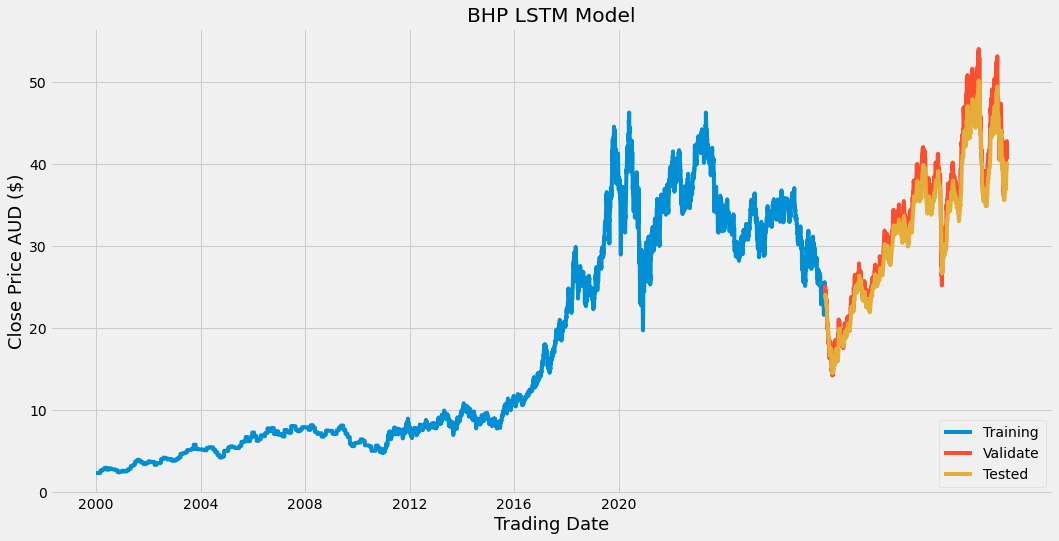

In [25]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('BHP LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/bhp_graph.png')
plt.show()

# Test data Predictions on the Model

In [26]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_25024/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
6972  24.680000    24.063538    0.616462
6973  25.120001    23.942745    1.177256
6974  25.000000    23.995762    1.004238
6975  24.709999    24.043249    0.666750
6976  23.990000    24.000902   -0.010902
...         ...          ...         ...
8710  42.189999    39.462551    2.727448
8711  42.810001    39.711792    3.098209
8712  42.189999    40.089886    2.100113
8713  41.750000    40.132126    1.617874
8714  40.599998    39.973114    0.626884

[1743 rows x 3 columns]>

In [27]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.bhp.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [28]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [29]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

31/08/2022 Last close $40.599998474121094 Predicted next day share price $39.28


# Save the Model

In [30]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/bhp_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list bhp_sixty and load df

#PREDICT USING LOADED MODEL

In [31]:
from keras.models import load_model
model_in = load_model('../static/bhp_model.sav')

In [32]:
# query the bhp collection and load into dataframe

df_mongo = pd.DataFrame(list(db.bhp.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[47.189999  ],
       [46.130001  ],
       [44.810001  ],
       [43.16      ],
       [43.720001  ],
       [43.849998  ],
       [42.07      ],
       [40.16      ],
       [40.630001  ],
       [40.700001  ],
       [39.610001  ],
       [39.490002  ],
       [40.560001  ],
       [41.549999  ],
       [42.32      ],
       [41.25      ],
       [40.049999  ],
       [39.43      ],
       [39.880001  ],
       [37.720001  ],
       [38.009998  ],
       [39.099998  ],
       [38.        ],
       [37.450001  ],
       [36.599998  ],
       [37.        ],
       [35.830002  ],
       [36.099998  ],
       [36.610001  ],
       [36.709999  ],
       [36.360001  ],
       [36.380001  ],
       [36.630001  ],
       [37.75      ],
       [37.360001  ],
       [37.735001  ],
       [38.465     ],
       [38.919998  ],
       [38.189999  ],
       [37.919998  ],
       [38.080002  ],
       [38.04000092],
       [38.63000107],
       [38.63999939],
       [38.29999924],
       [38

#Create a function to loop through the days input

In [33]:
from keras.models import load_model
model_in = load_model('../static/bhp_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_bhp(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_bhp(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[40.94,
 40.76,
 40.66,
 40.58,
 40.54,
 40.5,
 40.44,
 40.39,
 40.34,
 40.29,
 40.24,
 40.19,
 40.14,
 40.09,
 40.04,
 39.99,
 39.95,
 39.9,
 39.86,
 39.81,
 39.77,
 39.73,
 39.69,
 39.65,
 39.61,
 39.57,
 39.53,
 39.5,
 39.48,
 39.45,
 39.43,
 39.4,
 39.38,
 39.39,
 39.38,
 39.38,
 39.38,
 39.37,
 39.36,
 39.35,
 39.35,
 39.34,
 39.34,
 39.34,
 39.33,
 39.34,
 39.35,
 39.35,
 39.37,
 39.38,
 39.39,
 39.4,
 39.4,
 39.41,
 39.42,
 39.42,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.43,
 39.42,
 39.42,
 39.42,
 39.42,
 39.42,
 39.42,
 39.42,
 39.41,
 39.41,
 39.41,
 39.41,
 39.41,
 39.41,
 39.41,
 39.41,
 39.41,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39.4,
 39

In [34]:
#Create a date_df :
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  02-09-2022     Friday
1        2  05-09-2022     Monday
2        3  06-09-2022    Tuesday
3        4  07-09-2022  Wednesday
4        5  08-09-2022   Thursday
..     ...         ...        ...
203    204  14-06-2023  Wednesday
204    205  15-06-2023   Thursday
205    206  16-06-2023     Friday
206    207  19-06-2023     Monday
207    208  20-06-2023    Tuesday

[208 rows x 3 columns]>


In [35]:
#UPDATE DATES IN MONGODB AND CHECK IF UPDATED ALEADY
today4 = date.today()
d=today4+timedelta(days=1)
d=d.strftime('%d-%m-%Y')
print("Today plus one day:   "+d)
#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
d_mdb = dates_df.iloc[0,2]
print("Predicted next date in mongodb:   "+d_mdb)
# print(d,d_mdb)

def update_date():
    # Drop all previous records now in MongoDb
    db.dates.drop()
    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_mongo = pd.DataFrame(list(db.dates.find()))
    dates_updated = dates_mongo.iloc[:,1:].values
    return dates_updated

if d==d_mdb:
    print("Awesome! dates are already correctly updated!")
else:
    print("Dates need to be updated"+d+"  "+d_mdb)
    dates_updated = update_date()
    print(dates_updated)


Today plus one day:   02-09-2022
Predicted next date in mongodb:   02-09-2022
Awesome! dates are already correctly updated!


In [36]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
dates_val

,Count,Date,DOW
0,1,02-09-2022,Friday
1,2,05-09-2022,Monday
2,3,06-09-2022,Tuesday
3,4,07-09-2022,Wednesday
4,5,08-09-2022,Thursday
...,...,...,...
203,204,14-06-2023,Wednesday
204,205,15-06-2023,Thursday
205,206,16-06-2023,Friday
206,207,19-06-2023,Monday


C:\Users\antoi\AppData\Local\Temp/ipykernel_25024/3586780008.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


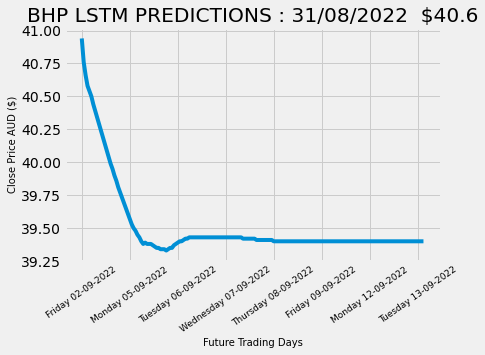

In [37]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,3]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,3]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,3]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,3]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,3]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,3]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,3]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,3]+" "+dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('BHP LSTM PREDICTIONS : '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/bhp_pred.png', bbox_inches="tight")
plt.show()

In [38]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('630ffb2b41269e1989242178'), 'Count': 1, 'Date': '02-09-2022', 'DOW': 'Friday', 'Price': 40.94}


In [39]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


6972 8715 8877


C:\Users\antoi\AppData\Local\Temp/ipykernel_25024/1163646243.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


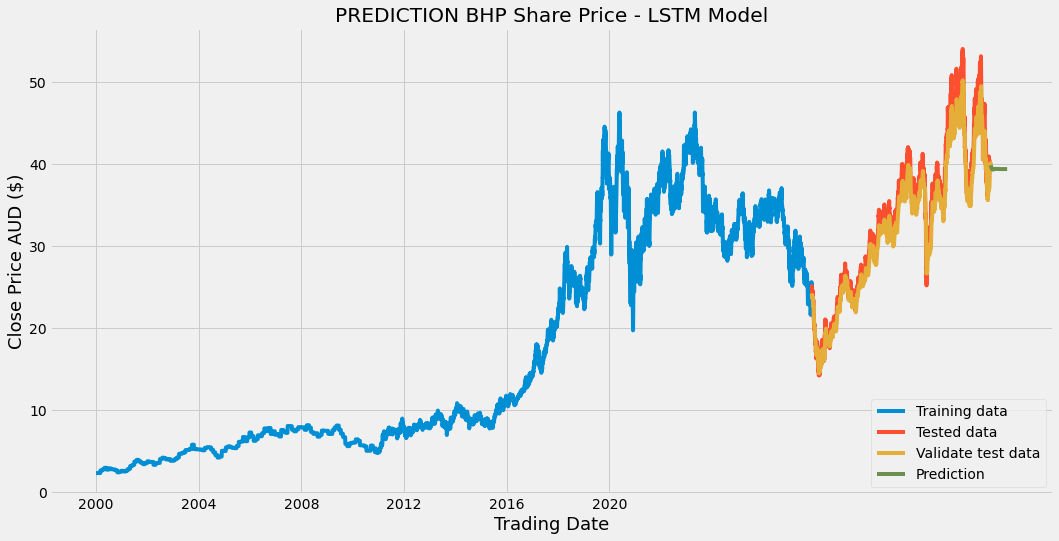

In [40]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION BHP Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/bhp_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [41]:
# Query all
name = 'BHP'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f72f48de00168f436699ef'), 'model': 'RFR', 'name': 'BHP', 'date': '12/08/2022', 'predicted': 42, 'actual': 38, 'difference': 4.9902, 'accuracy': 96.75}
{'_id': ObjectId('630dc69bfa90e1fdc0f38f71'), 'model': 'LSTM', 'name': 'BHP', 'date': '30/08/2022', 'predicted': 37.73, 'actual': 41.75, 'difference': -4.02, 'rmse': 3.30176}


In [42]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f72f48de00168f436699ef'), 'model': 'RFR', 'name': 'BHP', 'date': '12/08/2022', 'predicted': 42, 'actual': 38, 'difference': 4.9902, 'accuracy': 96.75}


In [43]:
# Set keys and values of company
name = 'BHP'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 31/08/2022,predicted $39.28, actual $40.6, difference -1.3200000000000003, rmse 1.33096


In [44]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f72f48de00168f436699ef'), 'model': 'RFR', 'name': 'BHP', 'date': '12/08/2022', 'predicted': 42, 'actual': 38, 'difference': 4.9902, 'accuracy': 96.75}
{'_id': ObjectId('630ffb2daf6bd6bfd1469dfa'), 'model': 'LSTM', 'name': 'BHP', 'date': '31/08/2022', 'predicted': 39.28, 'actual': 40.6, 'difference': -1.32, 'rmse': 1.33096}


In [45]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'

In [46]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'